<a href="https://colab.research.google.com/github/rryoung98/Prime-Number-Factoring/blob/main/Factoring_with_Shor's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Factoring prime numbers using Shor's Algorithm. Shor's Algorithm is used for factoring integers in polynomial time. The objective of this project is to compare qiskit and qbraid quantum machines in factoring prime numbers. 


In [1]:
#Use pip install for qiskit, shor, aqua and backend as needed for runtime
# !pip install qiskit
# !pip install Shor
# !pip install aqua
# !pip install backend
# !pip install -U matplotlib

In [8]:
#Import packages and qiskit libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
# import backend
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor
from qiskit.components.oracles import TruthTableOracle
from math import gcd
from numpy.random import randint
from fractions import Fraction
print("Imports Successful")

ModuleNotFoundError: No module named 'qiskit.components'

# Getting Started
If you've heard of quantum computing breaking RSA encrpytion. You're in the right place. Shor's algorithm developed in 1994 by American mathematician Peter Shor, is a cornerstone of quantum computing and is used for factoring prime numbers, which are integers that are not 0 or $\pm 1$ that is not disisbile without remainder by any other integer except $\pm 1$ or $\pm$ itself.




SyntaxError: invalid syntax (4058542738.py, line 2)

Shor's algorithm works by using the period by period finding. 

## Overview of Shor's Algorithm

https://medium.com/a-bit-of-qubit/shors-algorithm-how-does-it-work-aa6153646419


2. Shor’s Algorithm: Steps
With all the necessary definitions above, now we can go through the steps of Shor’s algorithm which he introduced in 1994 [3].

Our objective is to find factors (prime) of a number N=p⋅q.

Pick a number a, which is a co-prime with N. (Classical computer);
Need to find the smallest r such that aʳ≡1(mod N).
If r is even: Go to the next step. If r is odd go back to pick another a.
If r is even then we found the non-trivial square root of N;
Define x=pow(a, r/2). (Classical computer);
If x+1≡0(mod N); then one of p,q is contained in gcd(x+1, N) or gcd(x−1, N). (Classical computer);
If these fail (from step 3); we start everything by considering different a.

 

In [ ]:
#Setting N = 15 and a = 7
N = 15
a = 7

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')




First, we will set up a quantum circuit for period function f(x)=axmodN where a = 7 and N = 15. 




To find the prime numbers of 15, using Shor's algorithm the steps will be to first find a co-prime of 15. Ie we need to find the smallest $r$ such that aʳ≡1(mod N). We first begin with the number 7 and need to check if it satisfies the condition of being a co-prime ie $7c=1(\text{mod}15)$. When we check we do find that the integer $c=2$ satisifies our condition. However, when trying to accomplish prime factorization we need to apply a stricter rule and find non-trivial square root of primes $a^r=1(\text{mod}15)$. A non-trivial square root is extremely helpful in finding primes.


# Getting Started
We'll first start with picking 

In [ ]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 11)
print(a)

7


In [11]:
N=12

In [ ]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [ ]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [ ]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

In [ ]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [ ]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

In [ ]:
from qiskit import IBMQ, Aer
# provider = IBMQ.load_account()
# available_cloud_backends = provider.backends() 
# print('\nHere is the list of cloud backends that are available to you:')
# for i in available_cloud_backends: print(i)

available_local_backends = Aer.backends() 
print('\nHere is the list of local backends that are available to you: ')
for i in available_local_backends: print(i)



Here is the list of local backends that are available to you: 
qasm_simulator
statevector_simulator
unitary_simulator
pulse_simulator


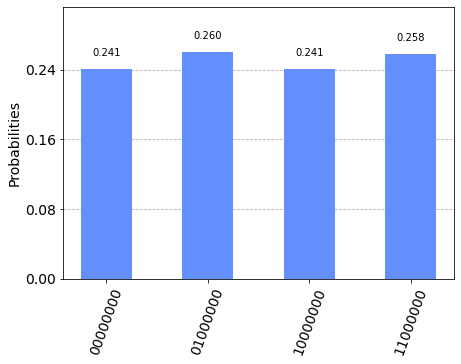

In [ ]:
aer_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [ ]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [ ]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [ ]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [ ]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


Factoring using period finding.

In [ ]:
N = 31


In [ ]:
np.random.seed(3) # This is to make sure we get reproduceable results
a = randint(1, 27)
print(a)

11


In [ ]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [ ]:
def qpe_amod31(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [ ]:
phase = qpe_amod31(a) # Phase = s/r
Fraction(phase).limit_denominator(31) # Denominator should (hopefully!) tell us r

Register Reading: 00000000
Corresponding Phase: 0.000000


Fraction(0, 1)

In [ ]:
frac = Fraction(phase).limit_denominator(31)
s, r = frac.numerator, frac.denominator
print(r)

1


In [ ]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[31, 1]


# Scaling of number of iterations vs N
Big O notation.


In [ ]:
a = 11
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod31(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

# My Shor's Factoring Algorithm

After checking out the pre-build Shor's algorithm, let's try and code it ourselves. 

## Implementing QPE (Quantum Phase Estimation)

QPE is an algoirthm which allows the estimation of $\theta$ in $U|{\psi}\rangle. = \exp^{2\pi i \theta}$. This is an important portion of Shor's algorithm because finding the prime number requires finding the period $|\psi\rangle = \frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}|\chi_s \rangle = | \phi \rangle$. 

In [18]:
import cirq
n_count = 8
counting_qubits = cirq.GridQubit.rect(n_count,1)

print(qubits[0])

q(0, 0)


We initialize our qubit with the eigenstate using the X gate.

In [19]:
cirq.X(qubits[-1])
print(counting_qubits)

[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(3, 0), cirq.GridQubit(4, 0), cirq.GridQubit(5, 0), cirq.GridQubit(6, 0), cirq.GridQubit(7, 0)]


In [23]:
for qubit in counting_qubits[:-1]:
    cirq.H(qubit)

In [24]:
zo# qBraid's tutorial on Shor's factoring algorithm (ie qiskit's old version)
N = 31 #Enter an odd integer > 1


backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = shor.run(quantum_instance)
print(f"The list of factors of {N} as computed by the Shor's algorithm is {result['factors'][0]}.")

NameError: name 'Aer' is not defined

In [ ]:
print(f'Computed of qubits for circuit: {4 * math.ceil(math.log(N, 2)) + 2}')
print(f'Actual number of qubits of circuit: {shor.construct_circuit().num_qubits}')

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

# Classical Factorization

In [ ]:
num=int(input("enter a number"))
factors=[]
for i in range(1,num+1):
    if num%i==0:
       factors.append(i)

print ("Factors of {} = {}".format(num,factors))

# Sieve of Eratosthenes

In [ ]:
# Python program to print all Primes Smaller
# than or equal to N using Sieve of Eratosthenes


def SieveOfEratosthenes(num):
	prime = [True for i in range(num+1)]
# boolean array
	p = 2
	while (p * p <= num):

		# If prime[p] is not
		# changed, then it is a prime
		if (prime[p] == True):

			# Updating all multiples of p
			for i in range(p * p, num+1, p):
				prime[i] = False
		p += 1

	# Print all prime numbers
	for p in range(2, num+1):
		if prime[p]:
			print(p)


# Driver code
if __name__ == '__main__':
	num = 50
	print("Following are the prime numbers smaller"),
	print("than or equal to", num)
	SieveOfEratosthenes(num)


Following are the prime numbers smaller
than or equal to 50
2
3
5
7
11
13
17
19
23
29
31
37
41
43
47
